/tmp/ipykernel_172829/2990960784.py:222: ComplexWarning: Casting complex values to real discards the imaginary part
  freq1D[j] = (Siso+R20cs+np.sqrt(1.5)*R20Q+0.5*(R2m2Q*R2p2Q-R2m1Q*R2p1Q)/wX+3*(qcsa2+qacs2)); # 1 <-> 0
/tmp/ipykernel_172829/2990960784.py:223: ComplexWarning: Casting complex values to real discards the imaginary part
  freq2D[j] = (Siso+R20cs-np.sqrt(1.5)*R20Q+0.5*(R2m2Q*R2p2Q-R2m1Q*R2p1Q)/wX-3*(qcsa2+qacs2)); # 0 <-> -1
/tmp/ipykernel_172829/2990960784.py:228: ComplexWarning: Casting complex values to real discards the imaginary part
  qcsa[j] = (-0.5*(R2m1Q*R2p1cs+R2p1Q*R2m1cs)/wX)
/tmp/ipykernel_172829/2990960784.py:229: ComplexWarning: Casting complex values to real discards the imaginary part
  qacs[j] = (0.5*(R2m1Q*R1p1acs-R2p1Q*R1m1acs)/wX)


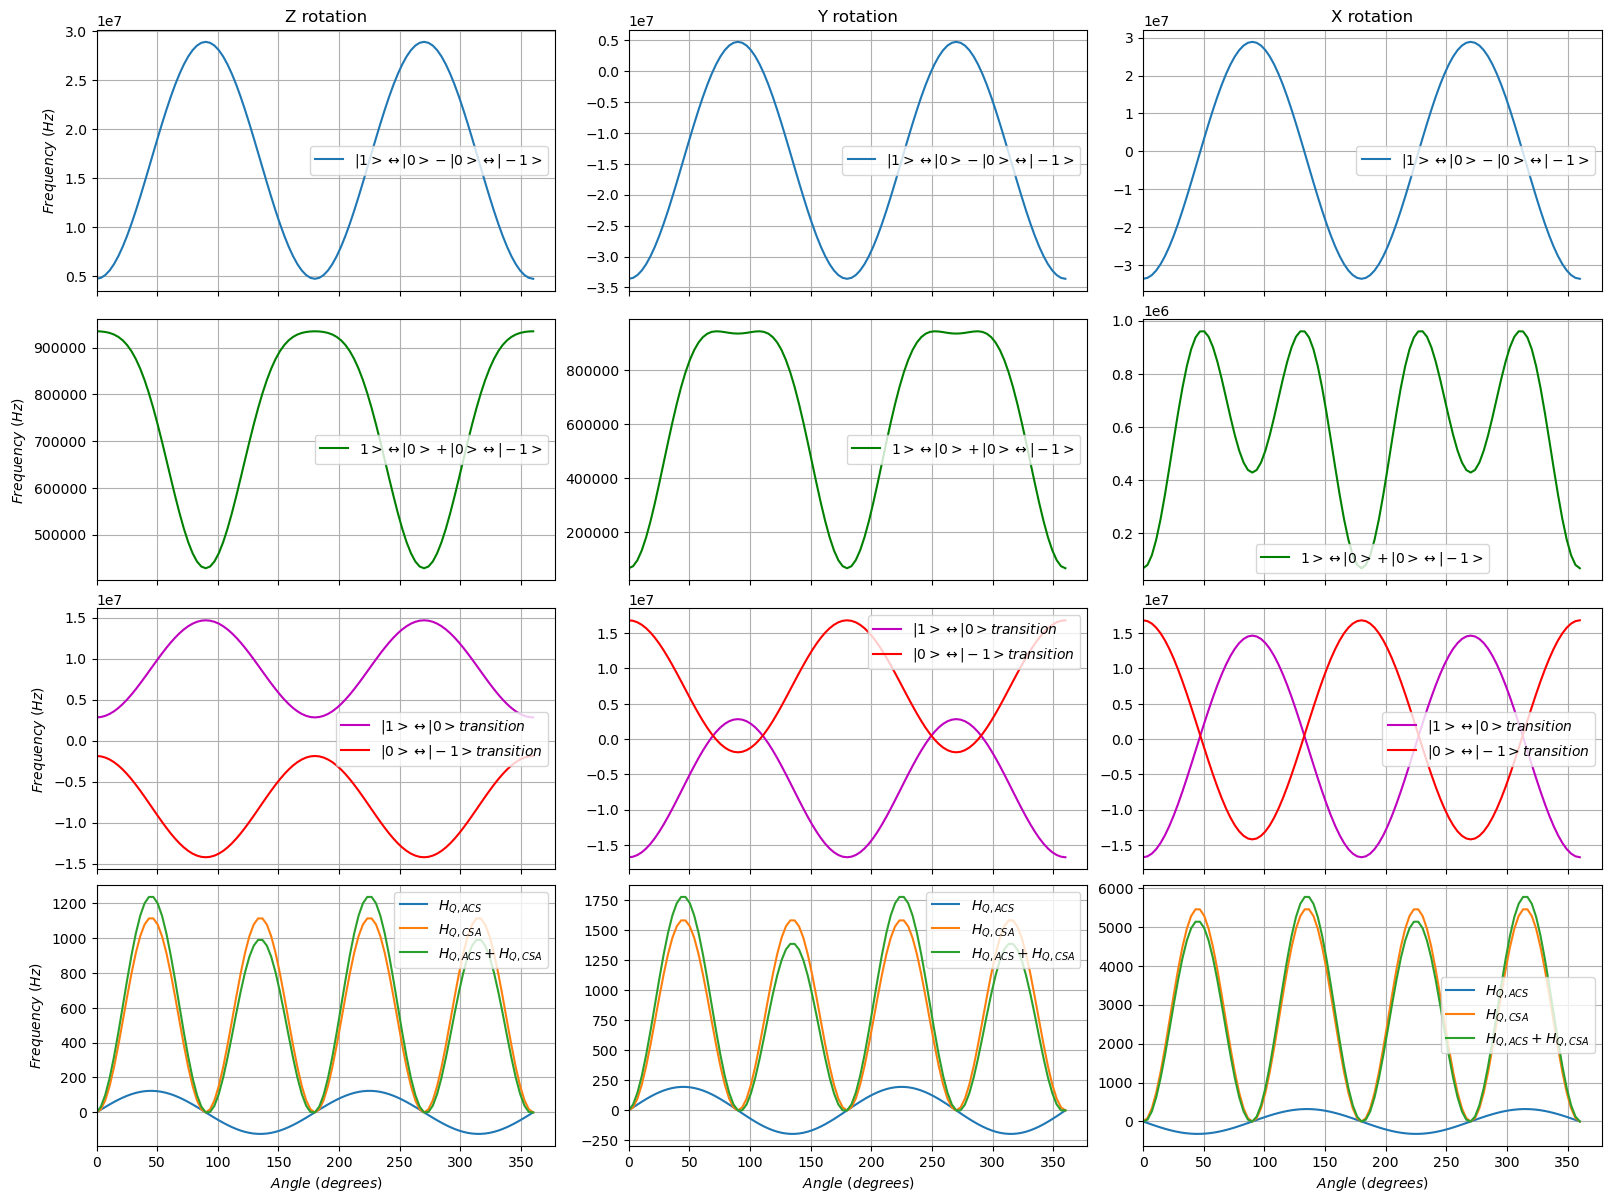

In [1]:
from symfit import parameters, variables, sin, cos, Fit
from scipy import optimize
import tabulate as tabulate
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import glob
import cmath

def Rabc(alfal, betal, gamal): #Euler Rotation Matrix
    U = np.zeros((3, 3))
    U[0, 0] = np.cos(alfal)*np.cos(betal)*np.cos(gamal) - np.sin(alfal)*np.sin(gamal)
    U[0, 1] = np.sin(alfal)*np.cos(betal)*np.cos(gamal) + np.cos(alfal)*np.sin(gamal)
    U[0, 2] = -np.sin(betal)*np.cos(gamal)
    U[1, 0] = -np.cos(alfal)*np.cos(betal)*np.sin(gamal) - np.sin(alfal)*np.cos(gamal)
    U[1, 1] = -np.sin(alfal)*np.cos(betal)*np.sin(gamal) + np.cos(alfal)*np.cos(gamal)
    U[1, 2] = np.sin(betal)*np.sin(gamal)
    U[2, 0] = np.cos(alfal)*np.sin(betal)
    U[2, 1] = np.sin(alfal)*np.sin(betal)
    U[2, 2] = np.cos(betal)
    return U

def Quad(QXG, ct, st, s2t, c2t, cp, sp, c2p, s2p): #Quadrupolar Interaction Function
    sq15 = np.sqrt(1.5)
    sq6 = np.sqrt(6)
    R20Q = (QXG[2,2]*(3*ct*ct-1)+2*QXG[0,2]*s2t*cp+2*QXG[1,2]*s2t*sp+(QXG[0,0]-QXG[1,1])*st*st*c2p+2*QXG[0,1]*st*st*s2p)
    R2q1 = 0.75*QXG[2,2]*s2t
    R2q2r = QXG[0,2]*c2t*cp
    R2q2i = QXG[0,2]*ct*sp
    R2q3r = QXG[1,2]*c2t*sp
    R2q3i = QXG[1,2]*ct*cp
    R2q4r = 0.25*(QXG[0,0]-QXG[1,1])*s2t*c2p
    R2q4i = 0.5*(QXG[0,0]-QXG[1,1])*st*s2p
    R2q5r = 0.5*QXG[0,1]*s2t*s2p
    R2q5i = QXG[0,1]*st*c2p
    R2p1Q = R2q1 - R2q2r + 1j*R2q2i - R2q3r - 1j*R2q3i - R2q4r + 1j*R2q4i - R2q5r - 1j*R2q5i
    R2m1Q=-R2q1+R2q2r+1j*R2q2i+R2q3r-1j*R2q3i+R2q4r+1j*R2q4i+R2q5r-1j*R2q5i;
  
    R4q1=0.75*QXG[2,2]*st*st;
    R4q2r=0.5*QXG[0,2]*s2t*cp; R4q2i=QXG[0,2]*st*sp;
    R4q3r=0.5*QXG[1,2]*s2t*sp; R4q3i=QXG[1,2]*st*cp;
    R4q4r=0.25*(QXG[0,0]-QXG[1,1])*(1+ct*ct)*c2p; R4q4i=0.5*(QXG[0,0]-QXG[1,1])*ct*s2p;
    R4q5r=0.5*QXG[0,1]*(1+ct*ct)*s2p; R4q5i=QXG[0,1]*ct*c2p;
    R2p2Q=R4q1-R4q2r+1j*R4q2i-R4q3r-1j*R4q3i+R4q4r-1j*R4q4i+R4q5r+1j*R4q5i;
    R2m2Q=R4q1-R4q2r-1j*R4q2i-R4q3r+1j*R4q3i+R4q4r+1j*R4q4i+R4q5r-1j*R4q5i;
    
    return [R2m2Q, R2m1Q, R20Q, R2p1Q, R2p2Q]
    

def ChemShift(CsaQXG, ct, st, s2t, c2t, cp, sp, c2p, s2p):
    sq15 = np.sqrt(1.5)
    R20cs = 0.5 *(1/3*(2 * CsaQXG[2, 2] - CsaQXG[0, 0] - CsaQXG[1, 1]) * (3*ct ** 2 - 1) +2 * CsaQXG[0, 2] * s2t * cp + 2 * CsaQXG[1, 2] * s2t * sp +(CsaQXG[0, 0] - CsaQXG[1, 1]) * st ** 2 * c2p + 2 * CsaQXG[0, 1] * st ** 2 * s2p)
    R2cs0 = 0.25 * (2 * CsaQXG[2, 2] - CsaQXG[0, 0] - CsaQXG[1, 1]) * s2t
    R2cs1r = CsaQXG[0, 2] * c2t * cp
    R2cs1i = CsaQXG[0, 2] * ct * sp
    R2cs2r = CsaQXG[1, 2] * c2t * sp
    R2cs2i = CsaQXG[1, 2] * ct * cp
    R2cs3r = 0.25 * (CsaQXG[0, 0] - CsaQXG[1, 1]) * s2t * c2p
    R2cs3i = 0.5 * (CsaQXG[0, 0] - CsaQXG[1, 1]) * st * s2p
    R2cs4r = 0.5 * CsaQXG[0, 1] * s2t * s2p
    R2cs4i = CsaQXG[0, 1] * st * c2p
    R2p1cs = R2cs0 - R2cs1r + 1j * R2cs1i - R2cs2r - 1j * R2cs2i - R2cs3r + 1j * R2cs3i - R2cs4r - 1j * R2cs4i
    R2m1cs = -R2cs0 + R2cs1r + 1j * R2cs1i + R2cs2r - 1j * R2cs2i + R2cs3r + 1j * R2cs3i + R2cs4r - 1j * R2cs4i
    
    return [R2m1cs, R20cs, R2p1cs]

def AntiShift(AcsQXG, ct, st, cp, sp):
    R11 = 0.5*(AcsQXG[0,1]-AcsQXG[1,0])*st
    R12 = 0.5*(AcsQXG[0,2]-AcsQXG[2,0])*cp
    R13 = 0.5*(AcsQXG[0,2]-AcsQXG[2,0])*ct*sp
    R14 = 0.5*(AcsQXG[1,2]-AcsQXG[2,1])*sp
    R15 = 0.5*(AcsQXG[1,2]-AcsQXG[2,1])*ct*cp
    R1p1acs = -1j*R11 + R12 - 1j*R13 + R14 + 1j*R15
    R1m1acs = 1j*R11 + R12 + 1j*R13 + R14 - 1j*R15
    
    return[R1m1acs, R1p1acs]

Nptx = 100
freq1D = np.zeros((Nptx+1,1))
freq2D = np.zeros((Nptx+1,1))
freqSUM = np.zeros((Nptx+1,1))
XX = np.zeros((Nptx+1,1))
freqDIFF = np.zeros((Nptx+1,1))
qacs = np.zeros((Nptx+1,1))
qcsa = np.zeros((Nptx+1,1))
# name = input('Enter Name of File:')
# w0 = float(input('Enter Larmor Frequency for nuclei in MHz:')) #Larmor fre in MHz #for N14
w0 = 43.4 #input for 14N
# print(w0)
wX = w0*10**6 #actual freq in Hz

ntheta  = 500
nphi = 500

dangle  = 2*np.pi/Nptx

#Spin Quantum Number
Ispin = 1.

#Quadrupolar Coupling Tensor
#coupling values for NAV (taken from paper https://pubmed.ncbi.nlm.nih.gov/22027340/)

CQ_M = -13.7175 #CQ in MHz
# CQ = 0
Qeta = 0.71998 #eta of Q

# Symmetric 2nd-rank chemical shift anisotropy (CSA)   tensor
# Siso_ppm = 0.     #isotropic chemical shift + offset(ppm)
delta_ppm = -841.792   #chemical shift anisotropy (CSA) (ppm)
eta = 1.07395   #eta of CSA

# CQ_M = -3.21 #CQ in MHz
# # CQ = 0
# Qeta = 0.32 #eta of Q

# # Symmetric 2nd-rank chemical shift anisotropy (CSA)   tensor
# Siso_ppm = 0.     #isotropic chemical shift + offset(ppm)
# delta_ppm = 110.  #chemical shift anisotropy (CSA) (ppm)
# eta = 0.415   #eta of CSA

# Antisymmetric 1st-rank chemical shift (ACS) tensor
Sxy = 50; Sxz = 50; Syz = 50




# Siso = Siso_ppm*w0
# delta = delta_ppm*w0

CQ = CQ_M*10**6/(2*Ispin*(2*Ispin-1))
Sxy = Sxy*w0; Sxz = Sxz*w0; Syz = Syz*w0;

delta = delta_ppm*w0
# Sxy = Sxy*wX; Sxz = Sxz*wX; Syz = Syz*wX;

# Siso = Siso_ppm*wX
# delta = delta_ppm*wX

# CQ = CQ_M*10**6/(2*Ispin*(2*Ispin-1))
# Sxy = Sxy*wX; Sxz = Sxz*wX; Syz = Syz*wX;

#*****Relative Tensor Orientations
#input parameters
#       {a,b,c)       {zeta,lamda,nu}         {alpha,beta,gama}           {phi,theta, 0}
# CSA===========>Quad==================>X-tal=======================>Gon=================>Lab

a, b, c = 0*np.pi/180, 0*np.pi/180, 0*np.pi/180
zeta, lamda, nu = 0*np.pi/180, 0*np.pi/180, 0*np.pi/180
alpha, beta, gama = 0*np.pi/180, 0*np.pi/180, 0*np.pi/180

# tensor parameter at PAS
QPAS = np.zeros((3, 3))
Csa = np.zeros((3, 3))
Acs = np.zeros((3, 3))

#Quadrupolar interactions
QPAS[0, 0] = (Qeta - 1) * CQ / 2
QPAS[1, 1] = -(1 + Qeta) * CQ / 2
QPAS[2, 2] = CQ

# 2nd-rank chemical shift anisotropy (CSA)

Csa[0, 0] = (eta - 1) * delta / 2
Csa[1, 1] = -(1 + eta) * delta / 2
Csa[2, 2] = delta
##############################################
# Siso_ppm = 1/3*(Csa[0,0] + Csa[1,1] + Csa[2,2]) #Siso is 1/3*Trace of CSA Tensor
Siso_ppm = 0
Siso = Siso_ppm*w0
##############################################

# 1st-rank antisymmetric chemical shift (ACS)

Acs[0, 1] = Sxy;  Acs[0, 2] = Sxz
Acs[1, 0] = -Sxy; Acs[1, 2] = Syz
Acs[2, 0] = -Sxz; Acs[2, 1] = -Syz

# Combining CSA and ACS
CSPAS = Csa + Acs


#Transformation between different frames
U = Rabc(a, b, c)
CsaQ = np.matmul(np.matmul(U, Csa), np.linalg.inv(U))
AcsQ = np.matmul(np.matmul(U, Acs), np.linalg.inv(U))
CSQ = np.matmul(np.matmul(U, CSPAS), np.linalg.inv(U))

U = Rabc(zeta, lamda, nu)
QX = np.matmul(np.matmul(U, QPAS), np.linalg.inv(U))
CsaQX = np.matmul(np.matmul(U, CsaQ), np.linalg.inv(U))
AcsQX = np.matmul(np.matmul(U, AcsQ), np.linalg.inv(U))
CSQX = np.matmul(np.matmul(U, CSQ), np.linalg.inv(U))

U = Rabc(alpha, beta, gama) 
QXG = np.matmul(np.matmul(U, QX), np.linalg.inv(U)); 
CsaQXG = np.matmul(np.matmul(U, CsaQX), np.linalg.inv(U));
AcsQXG = np.matmul(np.matmul(U, AcsQX), np.linalg.inv(U)); 
CSQXG = np.matmul(np.matmul(U, CSQX), np.linalg.inv(U));

df = [0]*3
for i in range(0,3):
    ang = 0 #starting angle
    for j in range(0, Nptx+1):
        text = ['z', 'y', 'x']

        atheta = [np.pi/2, ang, -ang] #-z, y, -x rotation
        aphi = [-ang, 0, np.pi/2]
          
        theta = atheta[i] 
        phi = aphi[i]
          
        ct = np.cos(theta); st = np.sin(theta); s2t = 2*ct*st; c2t = ct*ct-st*st;
        cp = np.cos(phi); sp = np.sin(phi); s2p = 2*cp*sp; c2p = cp*cp-sp*sp;
          
        R2m2Q, R2m1Q, R20Q, R2p1Q, R2p2Q = Quad(QXG,ct, st, s2t, c2t, cp ,sp ,c2p ,s2p)
        R2m1cs, R20cs, R2p1cs = ChemShift(CsaQXG,ct, st, s2t, c2t, cp, sp, c2p, s2p)
        R1m1acs, R1p1acs = AntiShift(AcsQXG,ct, st, cp, sp);
        qcsa2 = -0.5*(R2m1Q*R2p1cs+R2p1Q*R2m1cs)/wX;
        qacs2 = 0.5*(R2m1Q*R1p1acs-R2p1Q*R1m1acs)/wX;

        freq1D[j] = (Siso+R20cs+np.sqrt(1.5)*R20Q+0.5*(R2m2Q*R2p2Q-R2m1Q*R2p1Q)/wX+3*(qcsa2+qacs2)); # 1 <-> 0
        freq2D[j] = (Siso+R20cs-np.sqrt(1.5)*R20Q+0.5*(R2m2Q*R2p2Q-R2m1Q*R2p1Q)/wX-3*(qcsa2+qacs2)); # 0 <-> -1
        freqSUM[j] = freq1D[j]+freq2D[j]           #1 <-> -1 transition 
        freqDIFF[j] = freq1D[j]-freq2D[j]          #1 <-> -1 transition 
        

        qcsa[j] = (-0.5*(R2m1Q*R2p1cs+R2p1Q*R2m1cs)/wX)
        qacs[j] = (0.5*(R2m1Q*R1p1acs-R2p1Q*R1m1acs)/wX)
        
        XX[j]=ang*180/np.pi
        ang = ang + dangle
    
    data = np.column_stack((XX, np.real(freqSUM), np.real(freqDIFF), np.real(freq1D), np.real(freq2D), np.real(qacs), np.real(qcsa)))
    df[i]= pd.DataFrame(data, columns=['angle', 'fre_sum', 'freq_diff', 'freq_1D', 'freq_2D', 'ACS', 'CSA'])

    f_s=[0]*3
f_d=[0]*3
f_1D=[0]*3
f_2D=[0]*3
f_acs = [0]*3
f_csa = [0]*3
#***************************************
for i in range(0,3):
    # filename = name + text[i] + ".csv"
    # df[i] = pd.read_csv(filename, header = 0)
    # f_s[i] = df[i]['fre_sum']/1E6
    # f_d[i]= df[i]['freq_diff']/1E6
    # f_1D[i] = df[i]['freq_1D']/1E6 #freq of |1> -> |0>
    # f_2D[i] = df[i]['freq_2D']/1E6 #freq of |0> -> |-1>
    f_s[i] = df[i]['fre_sum']
    f_d[i]= df[i]['freq_diff']
    f_1D[i] = df[i]['freq_1D'] #freq of |1> -> |0>
    f_2D[i] = df[i]['freq_2D']
    f_acs[i] = df[i]['ACS']
    f_csa[i] = df[i]['CSA']
x_angle = df[i]['angle']

import matplotlib.pyplot as plt

Fig, axes = plt.subplots(nrows=4, ncols=3,figsize=(16,12), sharex=True,constrained_layout=True)
Fig.suptitle('', fontsize=24) #name of data file read
titles = ['Z rotation', 'Y rotation', 'X rotation']
axes[0,0].set_ylabel(r'$Frequency\ (Hz)$')
axes[1,0].set_ylabel(r'$Frequency\ (Hz)$')
axes[2,0].set_ylabel(r'$Frequency\ (Hz)$')
axes[3,0].set_ylabel(r'$Frequency\ (Hz)$')
for i in range(0,3): #using for loop to plot data for z, y and x
    axes[0,i].plot(x_angle,f_d[i], '-', label = r'$|1>\leftrightarrow|0> - |0>\leftrightarrow|-1>$')
    axes[0,i].set_title(titles[i])
    axes[0,i].set_xlim(left=0)

    axes[0,i].legend(loc='best') 
    axes[0,i].grid()
    axes[1,i].plot(x_angle,f_s[i], '-g', label = r'$1>\leftrightarrow|0> + |0>\leftrightarrow|-1>$')
    
    axes[1,i].legend(loc='best')
    axes[1,i].grid()

    axes[2,i].plot(x_angle,f_1D[i], '-m', label = r'$|1>\leftrightarrow|0> transition$')
    axes[2,i].plot(x_angle,f_2D[i], '-r',label = r'$|0>\leftrightarrow|-1> transition$')
    axes[2,i].legend(loc='best')
    axes[2,i].grid()

    axes[3,i].plot(x_angle, f_acs[i], label = r'$H_{Q, ACS}$')
    axes[3,i].plot(x_angle, f_csa[i], label = r'$H_{Q, CSA}$')
    axes[3,i].plot(x_angle, f_csa[i]+f_acs[i], label = r'$H_{Q, ACS} +H_{Q, CSA} $')
    axes[3,i].set_xlabel(r'$Angle\ (degrees)$')
    axes[3,i].legend(loc='best')
    axes[3,i].grid()